# ABOUT THE DATASET

Taking dataset from UCI Dataset: Heart Disease
 The "goal" field refers to the presence of heart disease in the patient.  

In [23]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
od.download("https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset")

Skipping, found downloaded files in ".\heart-disease-dataset" (use force=True to force download)


In [12]:
df=pd.read_csv(fr'C:\Users\Sarah\Desktop\task_03\heart-disease-dataset\heart.csv')

In [13]:
df.head(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0


age: age in years
sex: sex (1 = male; 0 = female)
cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
trestbps: resting blood pressure (in mm Hg on admission to the hospital)
chol: serum cholestoral in mg/dl
fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
thalach: maximum heart rate achieved
exang: exercise induced angina (1 = yes; 0 = no)
oldpeak = ST depression induced by exercise relative to rest
slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
 ca: number of major vessels (0-3) colored by flourosopy
 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

# Data Preprocessing and Cleansing

In [14]:
# Check for missing values
print(df.isnull().sum())

# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Check data types and basic statistics
print(df.info())
print(df.describe())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Number of duplicate rows: 723
<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 878
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory 

# Exploratory Data Analysis (EDA)

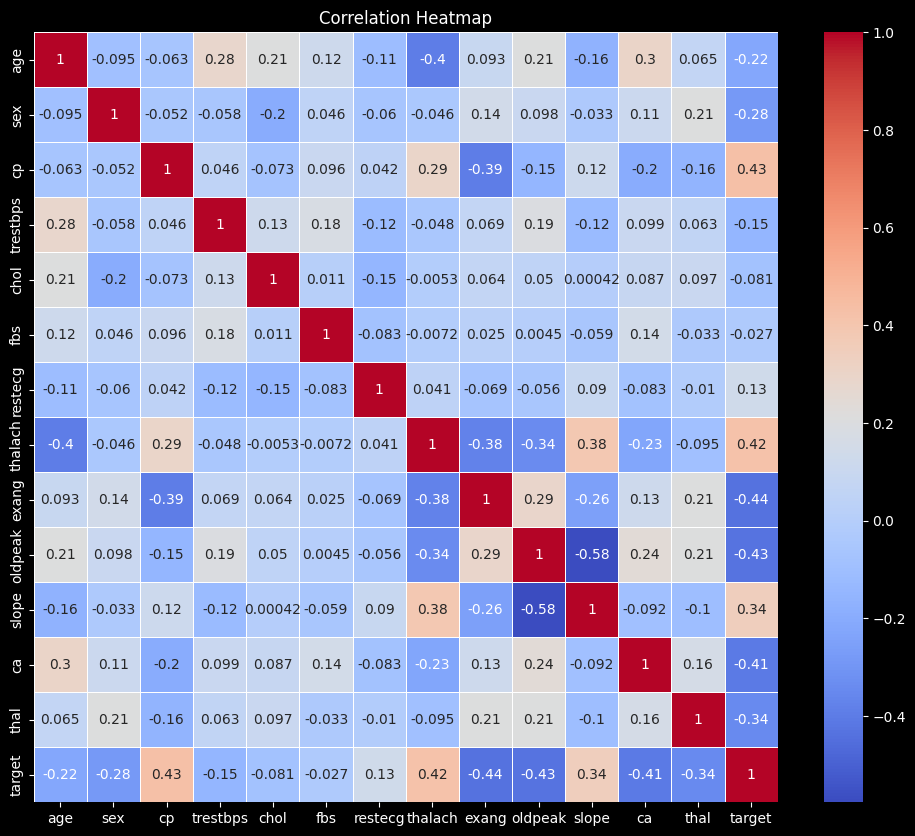

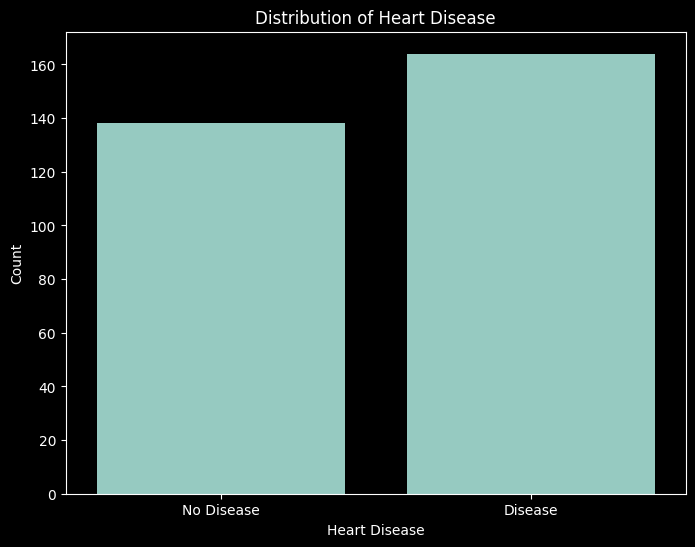

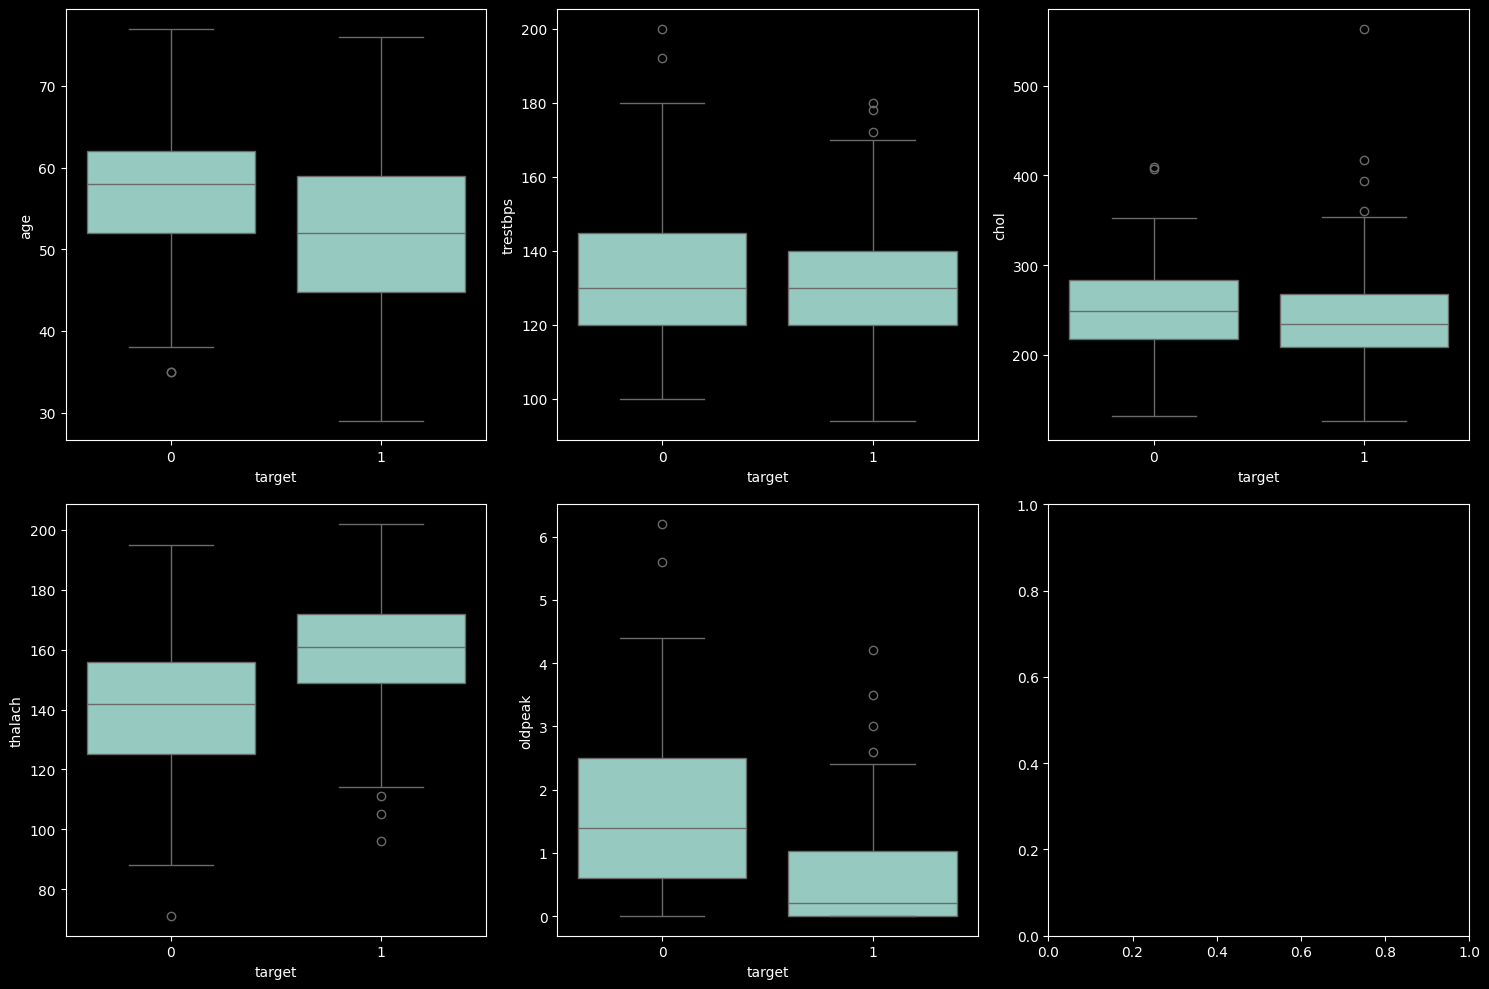

In [15]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.show()

# Box plots for numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    sns.boxplot(x='target', y=feature, data=df, ax=axes[i//3, i%3])
plt.tight_layout()
plt.show()

# Outlier Detection and Handling

In [16]:
def handle_outliers(df, column, method='cap'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    if method == 'cap':
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    elif method == 'remove':
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    df = handle_outliers(df, column, method='cap')


# Feature Selection And Engineering 

In [17]:
# Feature Selection
X = df.drop('target', axis=1)
y = df['target']

selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features:", selected_features)

# Feature Engineering
df['age_group'] = pd.cut(df['age'], bins=[0, 40, 60, 80, 100], labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])
df = pd.get_dummies(df, columns=['age_group'], drop_first=True)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_selected)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Selected features: ['age', 'sex', 'cp', 'trestbps', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


c:\Users\Sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Sarah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


#  Model Training and Hyperparameter Tuning

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8525

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85        32
         1.0       0.79      0.93      0.86        29

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61



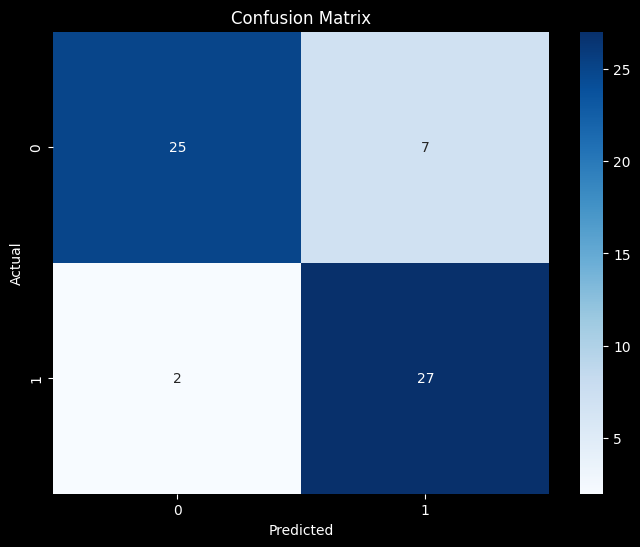

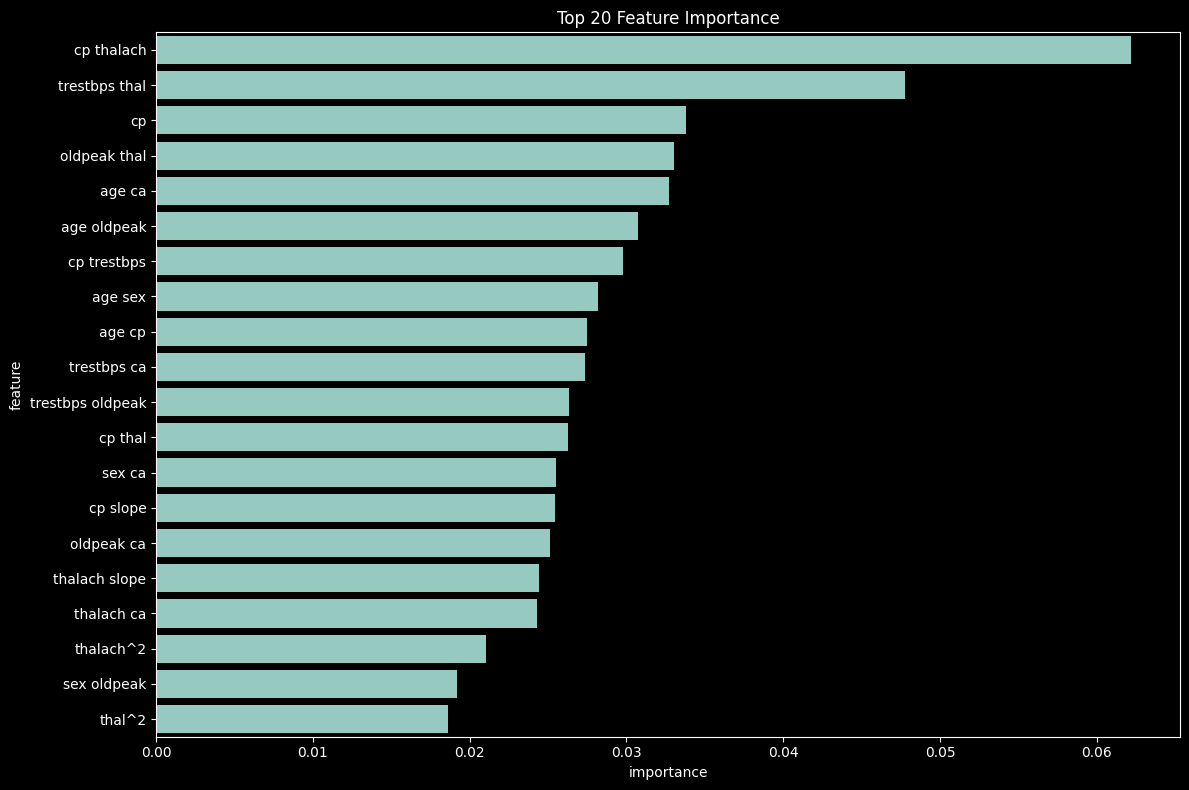

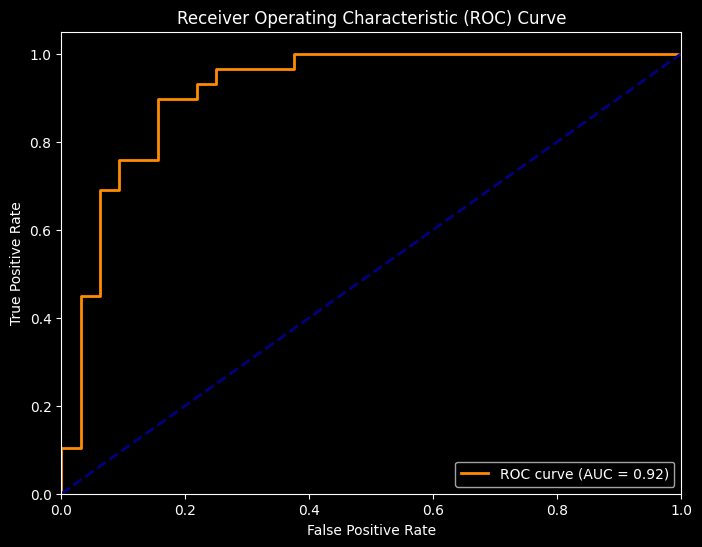

In [24]:
# Model Training and Hyperparameter Tuning
rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Model Evaluation
y_pred = best_rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance
# Get feature names after polynomial transformation
feature_names = poly.get_feature_names_out(selected_features)

# Create DataFrame with correct feature names
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 features for better visibility
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, best_rf.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()